<a href="https://colab.research.google.com/github/ninja-codes-droid/Machine_learning_project/blob/master/Potential_Lungs_Disease_Detection_Using_Chest_X_RAY_V2_Better.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Potential Lungs Disease Detection Using Chest X-RAY**

## Importing Required Libraries

In [1]:
import numpy as np # For Data processing
import tensorflow.keras as tk  # For Model processing 
import seaborn as sns  # Python data visualization library based on matplotlib
import matplotlib.pyplot as plt  # For Data Visualization
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For Data Preprocessing
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, TensorBoard ,ReduceLROnPlateau#For Getting The Best Model
from tensorflow.keras.optimizers import Adam # Optimizer 
from sklearn.metrics import classification_report,confusion_matrix # Generating Confusion matrix and classification_report of matrix 

## Data Acquisition
###### This is a Lungs Disease Dataset from kaggle authored by omkarmanohardalvi(https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types) ,The Dataset contains chest x-rays images. This Dataset was prepared from various datasets like he combined the datasets accordingly . It has 4 types of Lungs Diseases and a folder of Normal Lungs. He augmented the dataset with factor 6 so there are basically 10000 images.


### Download Dataset From Kaggle

In [2]:
# Install Kaggle Supporting Python Library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Mount Google Drive To Get The Kaggle Credentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Create A Temporary Storage To Store The Kaggle Credentials Into Root 
! mkdir ~/.kaggle

In [5]:
#Copy The Credentials From Google Drive To Temporary Storage
! cp '/content/drive/MyDrive/Colab Notebooks/Kaggle cred/kaggle.json' ~/.kaggle/kaggle.json

In [6]:
# Checking For The Credentials File
! ls -a /root/.kaggle

.  ..  kaggle.json


In [7]:
#Changing The Credentials File To Owner Only
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
#Downloading The Dataset From Kaggle 
! kaggle datasets download omkarmanohardalvi/lungs-disease-dataset-4-types

100% 2.02G/2.02G [01:42<00:00, 21.3MB/s]
100% 2.02G/2.02G [01:42<00:00, 21.2MB/s]


In [ ]:
#Unzip The Dataset 
! unzip /content/lungs-disease-dataset-4-types.zip

###Data Preprocessing

In [10]:
#Assigning Image Folders To Corresponding Variables 
train_dataset_path = '/content/Lung Disease Dataset/train'
validation_dataset_path ='/content/Lung Disease Dataset/val'
test_dataset_path = '/content/Lung Disease Dataset/test'

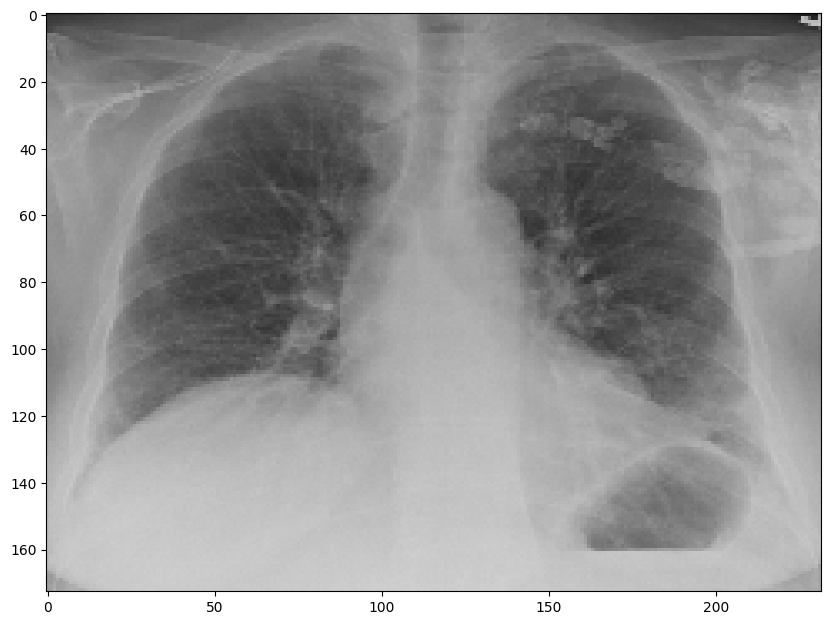

In [11]:
# simply show a picture
plt.figure(figsize= (10, 10))
img = plt.imread("/content/Lung Disease Dataset/train/Corona Virus Disease/00030347_000.png")
plt.imshow(img)
plt.show()

In [12]:
#Create Augmented Images With Below Variables
datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40,
                                                                  width_shift_range = 0.2,
                                                                  height_shift_range = 0.2,
                                                                  shear_range = 0.2,
                                                                  zoom_range = 0.2,
                                                                  horizontal_flip = True,
                                                                  fill_mode = 'nearest'
                                                                  )
#This generator reads images from train dataset and 
# create batches of augmented image data 
training_data  = datagen.flow_from_directory(train_dataset_path
                                                      ,target_size=(224,224),batch_size = 128,class_mode = 'categorical')   

Found 6054 images belonging to 5 classes.


In [13]:
# This generator reads images from validation ,test dataset and 
# create batches of augmented image data 

validation_data  = datagen.flow_from_directory(validation_dataset_path,target_size=(224,224),
                                                                                              batch_size = 128,class_mode = 'categorical')
test_data  = datagen.flow_from_directory(test_dataset_path,target_size=(224,224),
                                                                                              batch_size = 128,class_mode = 'categorical')
 

Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [14]:
# To Display The Dictionary Of Class
training_data.class_indices 

{'Bacterial Pneumonia': 0,
 'Corona Virus Disease': 1,
 'Normal': 2,
 'Tuberculosis': 3,
 'Viral Pneumonia': 4}

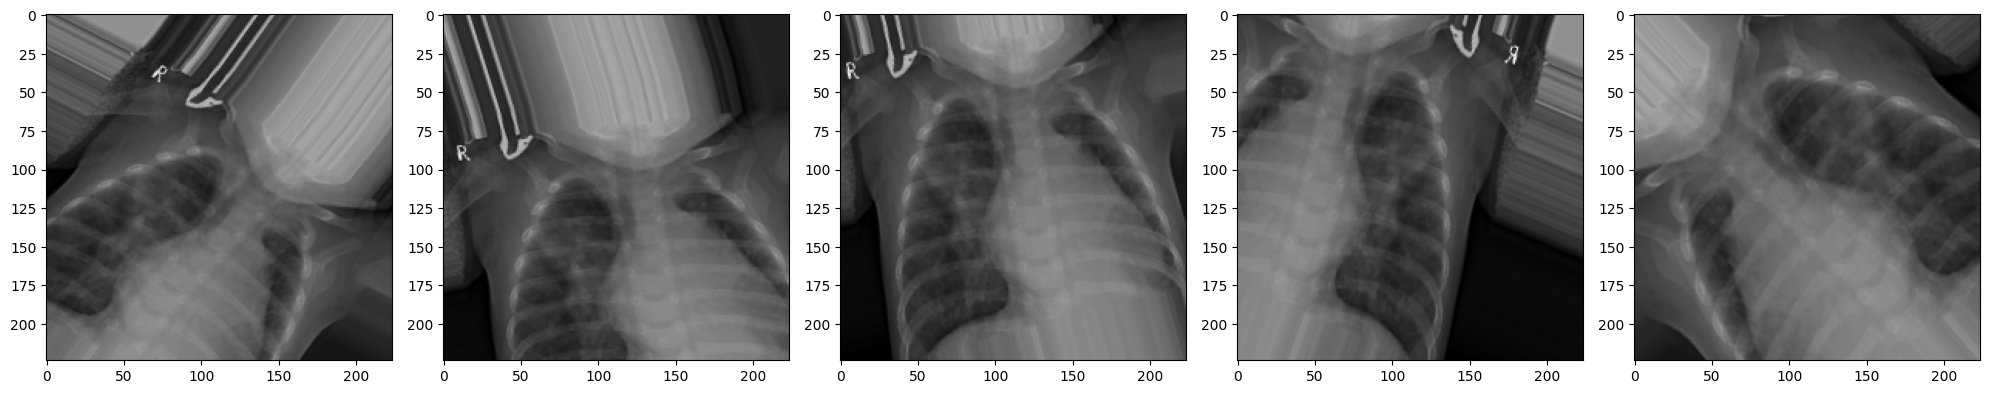

In [15]:
# To Display The Augmented Images
def plotImages(image_arr):
    fig, axes  = plt.subplots(1,5,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(image_arr, axes):
          ax.imshow(img)
    plt.tight_layout()
    plt.show()
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

##Model Building
###### A convolutional neural network (CNN) is a type of deep learning algorithm used for image recognition and processing of pixel data. Unlike other neural networks, CNNs are specifically designed for object recognition tasks, making them ideal for computer vision applications like self-driving cars and facial recognition. While there are other types of neural networks in deep learning, CNNs are the preferred choice for identifying and recognizing objects.

### Create CNN Model Using TensorFlow

In [16]:
#Creating CNN Model Using Sequential
model = tk.models.Sequential()

#### Adding Layers To CNN Model

In [17]:
#Adding First Convolutional Layer
model.add(tk.layers.Conv2D(32,(3,3),activation ='relu',input_shape=[224,224,3]))
#Adding First Pooling layer - MaxPooling 
model.add(tk.layers.MaxPooling2D(2,2))

#Adding Second Convolutional Layer
model.add(tk.layers.Conv2D(64,(3,3),activation ='relu'))
#Adding Second Pooling layer - MaxPooling
model.add(tk.layers.MaxPooling2D(2,2))

#Adding Third Convolutional Layer
model.add(tk.layers.Conv2D(32,(3,3),activation ='relu'))
#Adding Third Pooling layer - MaxPooling 
model.add(tk.layers.MaxPooling2D(2,2))

model.add(tk.layers.Dropout(0.5)) # To Reduce OverFitting 

model.add(tk.layers.Flatten()) #  To Make The Multidimensional Input Into One-Dimensional

#### Fully Connected Layer

In [18]:
# Create Dense layer(Neural Network)
model.add(tk.layers.Dense(units=128,activation='relu')) #Input Layer
model.add(tk.layers.Dropout(0.1))

model.add(tk.layers.Dense(units=256,activation='relu')) # Hidden Layer 1
model.add(tk.layers.Dropout(0.25))

model.add(tk.layers.Dense(units=512,activation='relu')) #Hidden Layer 2
model.add(tk.layers.Dropout(0.25))

model.add(tk.layers.Dense(units=128,activation='relu')) # Hidden Layer 3

model.add(tk.layers.Dense(units=5,activation='softmax')) # Output Layer

### Compiling And Training Model

#### Prevention Of Overfitting

In [19]:
#Early Stopping To When Hit The Minimum Validation Loss
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,  restore_best_weights=True)
# Saving The Model With Maximum Validation Accuracy
Checkpoint = tk.callbacks.ModelCheckpoint("Detect_model_v2.h5", monitor="val_accuracy", save_best_only= True, mode="max")
reduce_lr = ReduceLROnPlateau(monitor= "val_accuracy", factor= 0.5, patience= 4, verbose= 3,cooldown=2,  mode= "max", min_lr= 0.0000001)

#### Compiling Model

In [20]:
# Compiling With High Learning Rate
model.compile(optimizer  = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Summary Of The Model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

#### Training the Model


In [30]:
history=model.fit(training_data, epochs=50, verbose=1, callbacks=[reduce_lr, Checkpoint,es],validation_data=validation_data,batch_size=16) 

Epoch 1/50
48/48 [==============================] - 205s 4s/step - loss: 0.5092 - accuracy: 0.7940 - val_loss: 0.5072 - val_accuracy: 0.7927 - lr: 2.5000e-04
Epoch 2/50
48/48 [==============================] - 202s 4s/step - loss: 0.5019 - accuracy: 0.7942 - val_loss: 0.5184 - val_accuracy: 0.7808 - lr: 2.5000e-04
Epoch 3/50
48/48 [==============================] - 201s 4s/step - loss: 0.5106 - accuracy: 0.7939 - val_loss: 0.5039 - val_accuracy: 0.7956 - lr: 2.5000e-04
Epoch 4/50
48/48 [==============================] - 204s 4s/step - loss: 0.5106 - accuracy: 0.7919 - val_loss: 0.4885 - val_accuracy: 0.7981 - lr: 2.5000e-04
Epoch 5/50
48/48 [==============================] - 202s 4s/step - loss: 0.5049 - accuracy: 0.7915 - val_loss: 0.5052 - val_accuracy: 0.7941 - lr: 2.5000e-04
Epoch 6/50
48/48 [==============================] - 204s 4s/step - loss: 0.5028 - accuracy: 0.7937 - val_loss: 0.4985 - val_accuracy: 0.7976 - lr: 2.5000e-04
Epoch 7/50
48/48 [==============================] - 

## Model Evaluation
######Model evaluation is the process of using different evaluation metrics to understand a machine learning model’s performance, as well as its strengths and weaknesses. Model evaluation is important to assess the efficacy of a model during initial research phases, and it also plays a role in model monitoring.

###Ploting Charts On Training Data Over Validation Data

####Plotting The Losses Over Training


[]

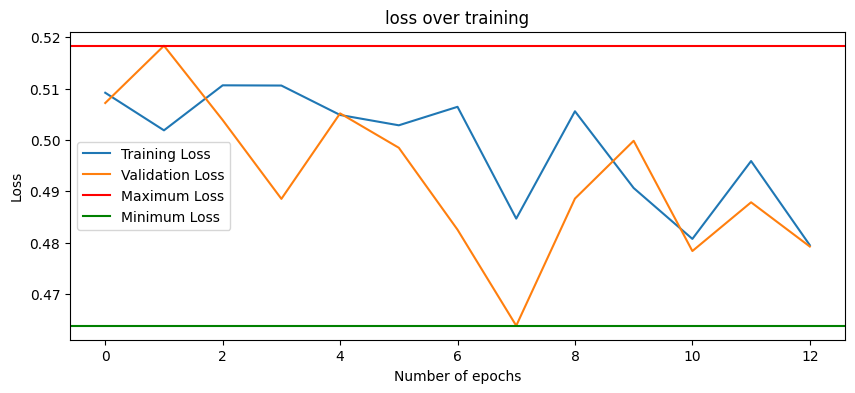

In [31]:
plt.figure(figsize=(10, 4))

plt.title("loss over training")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
plt.axhline(max_loss, color="red", label="Maximum Loss")

min_loss = min(min(history.history['loss']), min(history.history['val_loss']))
plt.axhline(min_loss, color="green", label="Minimum Loss")

plt.legend()
plt.plot()


####Plotting The Accuracy Over Training

[]

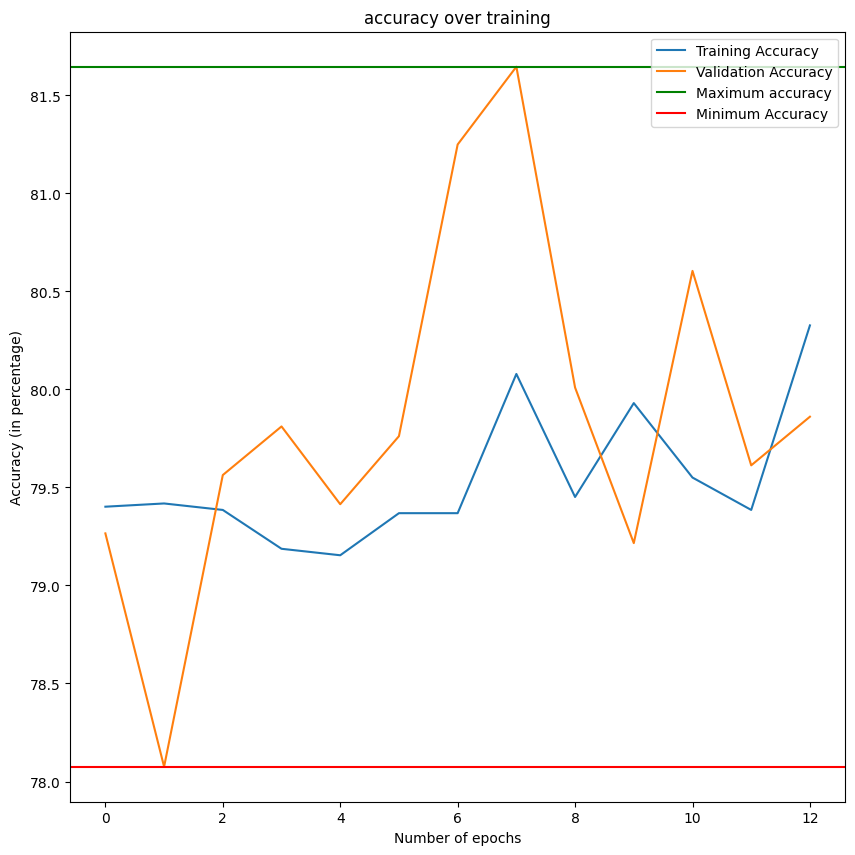

In [32]:
plt.figure(figsize=(10, 10))

plt.title("accuracy over training")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy (in percentage)")

plt.plot(100 * np.array(history.history['accuracy']), label='Training Accuracy')
plt.plot(100 * np.array(history.history['val_accuracy']), label='Validation Accuracy')

max_acc = 100 * max(max(history.history['accuracy']), max(history.history['val_accuracy']))
plt.axhline(max_acc, color="green", label="Maximum accuracy")

min_acc = 100 * min(min(history.history['accuracy']), min(history.history['val_accuracy']))
plt.axhline(min_acc, color="red", label="Minimum Accuracy")

plt.legend()
plt.plot()

### Accuracy On Testing Data

In [33]:
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print('Test accuracy:', test_acc)

16/16 - 50s - loss: 0.4675 - accuracy: 0.8138 - 50s/epoch - 3s/step
Test accuracy: 0.8138271570205688


#### Classification Report and Confusion Matrix

In [37]:
# Predict Output
STEP_SIZE_TEST = test_data.n//test_data.batch_size
test_data.reset()
pred=model.predict(test_data,
steps=STEP_SIZE_TEST,
verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

15/15 [==============================] - 48s 3s/step


In [38]:
current_idx = 0
count_accurate= 0
Actual = []
for i in predictions:
    string = test_data.filenames[current_idx]
    substr = '/'
    actual = string[:string.find(substr)]
    Actual.append(actual)
    pred = predictions[current_idx]
    if actual == pred: 
        count_accurate += 1
    current_idx +=1
acc = count_accurate/771
print(f"The accuracy on predicted the test images is {round(acc*100,2)}%.")

The accuracy on predicted the test images is 50.71%.


In [39]:
print(classification_report(Actual, predictions))

                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.21      0.19      0.20       403
Corona Virus Disease       0.21      0.20      0.20       407
              Normal       0.19      0.21      0.20       404
        Tuberculosis       0.25      0.25      0.25       408
     Viral Pneumonia       0.15      0.17      0.16       298

            accuracy                           0.20      1920
           macro avg       0.20      0.20      0.20      1920
        weighted avg       0.21      0.20      0.20      1920



##Saving The Model

In [40]:
#Saving The Model In Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Model/Detect_Model_v2.h5'
model.save(path)  # to save in google drive